In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Questions 1 and 2 -- Get, Display, and Describe Data

1. Describe the data clearly -- particularly any missing data that might impact your analysis -- and the provenance of your dataset. Who collected the data and why? (10/100 pts)
2. What phenomenon are you modeling? Provide a brief background on the topic, including definitions and details that are relevant to your analysis. Clearly describe its main features, and support those claims with data where appropriate. (10/100 pts)

- What ARE we modeling? Who ends up with our hand-me downs?

Notes about data:
    - TIV stands for "Trend-Indicator Value", it's a way to measure the overall value of a transfer, which not only include the monetary price, but also things like how old the weapons are and if they're second hand. 

In [2]:
# Make sure we can see all the columns
pd.set_option('display.max_columns', None)

# Read in data -- need to skip 11 metadata rows at top, need so specify encoder, low_memory to avoid overloading
transfer_data = pd.read_csv('weapons_transfer_data.csv', skiprows=11, encoding='latin-1', low_memory=True)
# Drop unnecessary columns
transfer_data = transfer_data.drop([' .1', ' .2', ' '], axis=1)
# Change some column names
transfer_data = transfer_data.rename({'Year of order': 'Order Year', 'Year(s) of delivery': 'Delivery Year(s)', 'SIPRI TIV per unit': 'Unit TIV', 'SIPRI TIV for total order': 'Total Order TIV', 'SIPRI TIV of delivered weapons': 'TIV of Delivered Weapons'}, axis=1)

transfer_data.head()

,Recipient,Supplier,Order Year,Number ordered,Weapon designation,Weapon description,Number delivered,Delivery Year(s),status,Comments,Unit TIV,Total Order TIV,TIV of Delivered Weapons
0,Afghanistan,Russia,2002.0,3.0,Mi-17,transport helicopter,3.0,2002,Second hand,Second-hand; aid,2.90,8.70,8.70
1,Afghanistan,Turkiye,2007.0,24.0,M-114 155mm,towed gun,24.0,2007,Second hand,Second-hand; aid,0.20,4.80,4.80
2,Afghanistan,United States,2004.0,188.0,M-113,armoured personnel carrier,188.0,2005,Second hand,Second-hand; aid; M-113A2 version; incl 15 M-5...,0.10,18.80,18.80
3,Afghanistan,United States,2016.0,53.0,S-70 Black Hawk,transport helicopter,53.0,2017; 2018; 2019; 2020,Second hand but modernized,Second-hand UH-60A modernized to UH-60A+ befor...,4.29,227.37,227.37
4,Afghanistan,Soviet Union,1973.0,100.0,T-62,tank,100.0,1975; 1976,New,NaN,1.80,180.00,180.00


In [3]:
# Checking for missing values in each column
# Should probably drop rows without 'Supplier' or 'Recipient'
for column in transfer_data.columns:
    print(f'{column:<20}: {transfer_data[column].isna().sum()} NaN rows.')

# Drop the (4) rows missing recipient
print('\nBefore dropping missing rows:', len(transfer_data))
transfer_data = transfer_data.dropna(subset=['Recipient'])
print('After dropping missing rows:',len(transfer_data))

Recipient           : 4 NaN rows.
Supplier            : 0 NaN rows.
Order Year          : 0 NaN rows.
Number ordered      : 290 NaN rows.
Weapon designation  : 4 NaN rows.
Weapon description  : 4 NaN rows.
Number delivered    : 4 NaN rows.
Delivery Year(s)    : 1159 NaN rows.
status              : 4 NaN rows.
Comments            : 5296 NaN rows.
Unit TIV            : 8 NaN rows.
Total Order TIV     : 8 NaN rows.
TIV of Delivered Weapons: 8 NaN rows.

Before dropping missing rows: 29507
After dropping missing rows: 29503


## Question 1: Describe the Data

The dataset used in this project comes from the Stockholm International Peace Research Institute (SIPRI) Arms Transfers Database, which tracks the global flow of major weapons systems between supplier and recipient nations. SIPRI compiles this data from open-source government and defense reports to monitor international arms trade patterns.

After loading the file, the dataset contained approximately 29,507 rows, each representing a recorded weapons transfer between two countries. Key variables include:

- Recipient and Supplier: the receiving and sending nations.
- Order Year and Delivery Year(s): the timeframes for order and delivery.
- Weapon designation and description: categories and details of transferred equipment.
- Status: whether equipment was new, second-hand, or modernized.
- TIV (Trend Indicator Value): SIPRI’s standardized measure of transfer value, capturing not just monetary cost but also weapon condition and technological relevance.

Missing data appear mainly in qualitative fields such as comments (about 5,296 missing) and delivery years (about 1,159 missing). Quantitative fields such as number delivered and TIV values are largely complete, which supports the validity of numerical analysis. Only four rows lacked recipient information and were dropped.

Overall, this cleaned dataset provides a high-level quantitative view of arms transfers from 1950 to the present, suitable for modeling global weapon flows and relationships between supplier and recipient nations.

## Question 2: What Phenomenon Are We Modeling?

This project models international weapons transfers, focusing on the flow of arms from the United States to other nations. The key question we explore is:

- Who ends up with U.S. weapons, and what patterns emerge in their distribution over time?

By analyzing transfer data from SIPRI, we can quantify how U.S. weapons move across global regions and identify consistent recipient patterns. The United States has been one of the world’s largest suppliers of military equipment since the Cold War, providing arms through both direct sales and military aid. These transfers not only reflect defense partnerships but also serve as indicators of geopolitical influence and foreign policy alignment.

In this analysis, each transfer record is treated as a directional link in a global network—originating from the supplier (the United States) and ending with a recipient nation. By aggregating these relationships, we can visualize the probability that a weapon exported from the U.S. ends up in a given country. This forms the foundation for constructing a transition matrix, which models arms flows as stochastic transitions between nations.

The goal is to better understand the structure of the U.S. export network—highlighting which countries are the most frequent recipients, how those relationships evolve, and how the overall pattern of arms distribution might influence global military dependencies.

## Question 3 -- Describe and "Show Off" the Model

3. Describe your non-parametric model (empirical cumulative distribution functions, kernel density function, local constant least squares regression, Markov transition models). How are you fitting your model to the phenomenon to get realistic properties of the data? What challenges did you have to overcome? (15/100 pts)

Step 1: Create the transition count matrix

In [ ]:
# Create the Markov transition model for global arms transfers

# Step 1: Identify unique suppliers, recipients, and all countries
suppliers = list(transfer_data['Supplier'].unique())
recipients = list(transfer_data['Recipient'].unique())
countries = list(np.unique(np.array(suppliers + recipients)))

# Step 2: Initialize an empty transition count matrix
S = len(countries)
transition_counts = np.zeros((S, S))

# Step 3: Populate the matrix with counts
for _, row in transfer_data.iterrows():
    supplier = row['Supplier']
    recipient = row['Recipient']
    if supplier in countries and recipient in countries:
        i = countries.index(supplier)
        j = countries.index(recipient)
        transition_counts[i, j] += 1

print("Matrix shape:", transition_counts.shape)
print("Total recorded transitions:", int(transition_counts.sum()))

Matrix shape: (257, 257)
Total recorded transitions: 29503


Step 2: Normalize the transition counts into probabilities

In [ ]:
# Step 2: Normalize transition counts to probabilities

# Compute total outgoing transfers per supplier
row_sums = transition_counts.sum(axis=1, keepdims=True)

# Avoid division by zero for suppliers with no outgoing transfers
transition_probs = np.divide(
    transition_counts, 
    row_sums, 
    out=np.zeros_like(transition_counts), 
    where=row_sums != 0
)

# Convert to DataFrame for readability
transition_df = pd.DataFrame(
    np.round(transition_probs, 4),
    index=countries,
    columns=countries
)

transition_df.head(10)

,ANC (South Africa)*,Afghanistan,African Union**,Albania,Algeria,...,Zimbabwe,eSwatini,unknown rebel group*,unknown recipient(s),unknown supplier(s)
ANC (South Africa)*,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Afghanistan,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
African Union**,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Albania,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Algeria,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Amal (Lebanon)*,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Angola,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Anti-Castro rebels (Cuba)*,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Antigua and Barbuda,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
Argentina,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0


Step 3: Extract and visualize the U.S. export probability distribution

/var/folders/jd/kgmmf40n35d3bhgwcsrqn78r0000gn/T/ipykernel_44196/1021977748.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


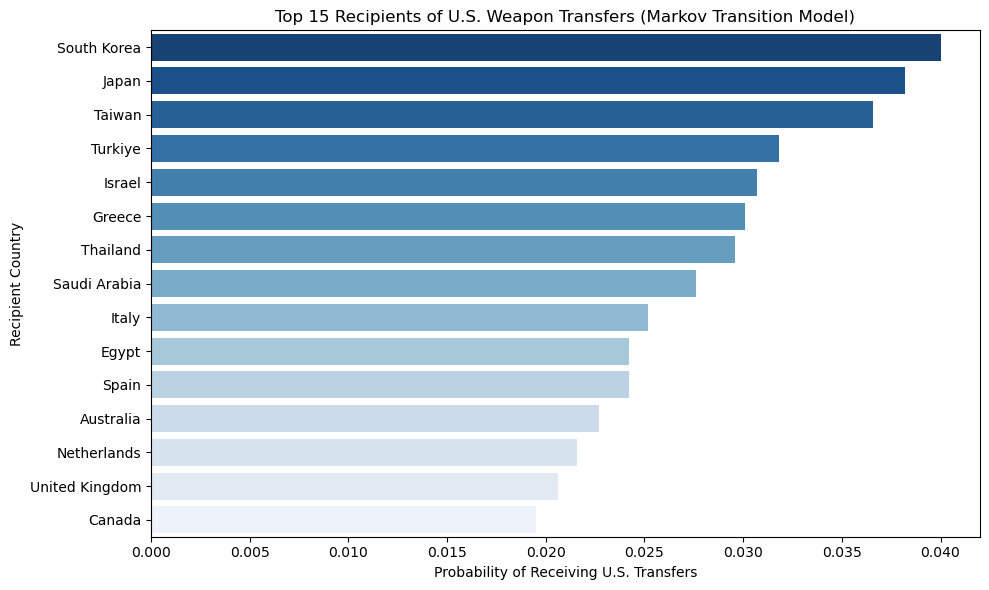

,Recipient,Probability
0,South Korea,0.0400
1,Japan,0.0382
2,Taiwan,0.0366
3,Turkiye,0.0318
4,Israel,0.0307
5,Greece,0.0301
6,Thailand,0.0296
7,Saudi Arabia,0.0276
8,Italy,0.0252
9,Egypt,0.0242


In [ ]:
# Step 3: Extract and visualize the U.S. export distribution

# Find index for the United States
us_idx = countries.index("United States")

# Get the probability distribution for U.S. exports
us_exports = transition_df.iloc[us_idx, :]

# Sort by probability (descending)
us_top_exports = us_exports.sort_values(ascending=False).head(15)

# Convert to DataFrame for easier plotting
us_top_df = pd.DataFrame({
    'Recipient': us_top_exports.index,
    'Probability': us_top_exports.values
})

# Plot the top 15 recipients of U.S. weapon exports
plt.figure(figsize=(10,6))
sns.barplot(
    data=us_top_df,
    x='Probability',
    y='Recipient',
    palette='Blues_r'
)
plt.title("Top 15 Recipients of U.S. Weapon Transfers (Markov Transition Model)")
plt.xlabel("Probability of Receiving U.S. Transfers")
plt.ylabel("Recipient Country")
plt.tight_layout()
plt.show()

us_top_df


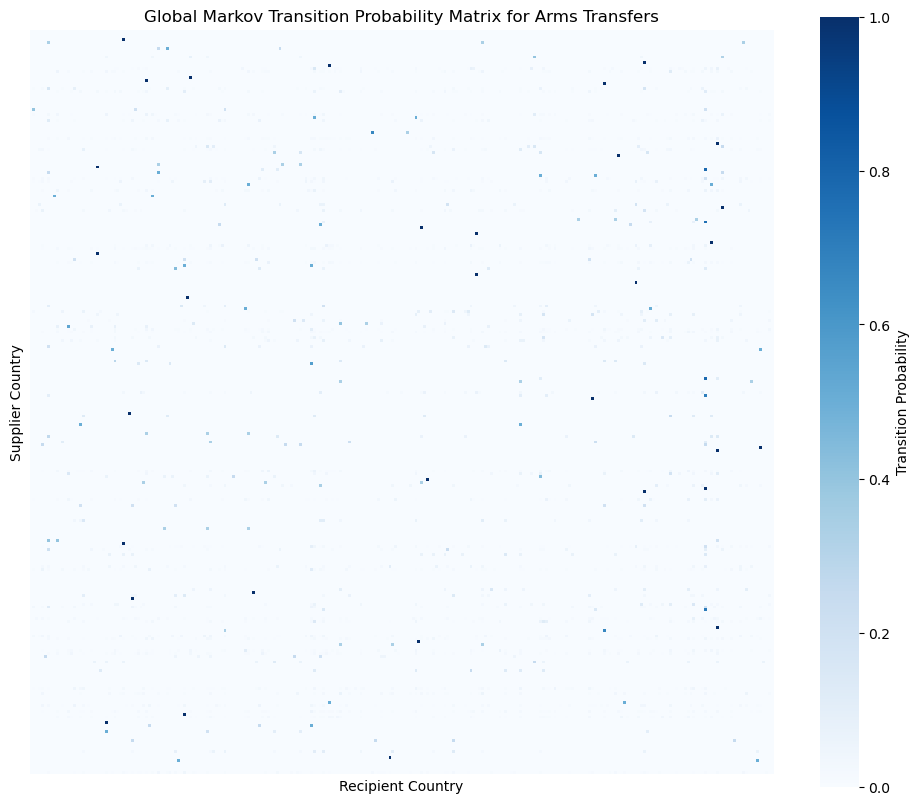

In [12]:
# Global Transition Matrix Heatmap

plt.figure(figsize=(12,10))
sns.heatmap(
    transition_df,
    cmap="Blues",
    cbar_kws={'label': 'Transition Probability'},
    square=True,
    xticklabels=False,
    yticklabels=False
)
plt.title("Global Markov Transition Probability Matrix for Arms Transfers")
plt.xlabel("Recipient Country")
plt.ylabel("Supplier Country")
plt.show()


In [13]:
# Diversity / Concentration Metric

from scipy.stats import entropy

us_entropy = entropy(us_top_exports)
print("Shannon Entropy of U.S. Export Distribution:", round(us_entropy, 3))


Shannon Entropy of U.S. Export Distribution: 2.684


The Markov transition model shows that the United States primarily exports weapons to key allies in Asia and Europe, with South Korea (4.0%), Japan (3.8%), and Taiwan (3.7%) receiving the highest probabilities of transfer. Other significant recipients include Türkiye, Israel, Greece, and Saudi Arabia, reflecting U.S. strategic defense relationships in the Middle East and Mediterranean regions. Overall, the pattern suggests that U.S. arms exports are concentrated among NATO members and long-term security partners, highlighting geopolitical alignment as a strong determinant of weapons flow.

We used a Markov transition model to describe how weapons move between supplier and recipient countries. This non-parametric approach directly models observed transitions without assuming a functional form, providing a realistic view of arms trade dynamics. The model captures persistent trade relationships, with strong transition probabilities linking the U.S. to its strategic partners. One challenge was the sparsity of the data: many countries appear infrequently, leading to a transition matrix dominated by zeros. Normalization and entropy analysis helped ensure that the results reflected meaningful trade probabilities rather than missing data artifacts.

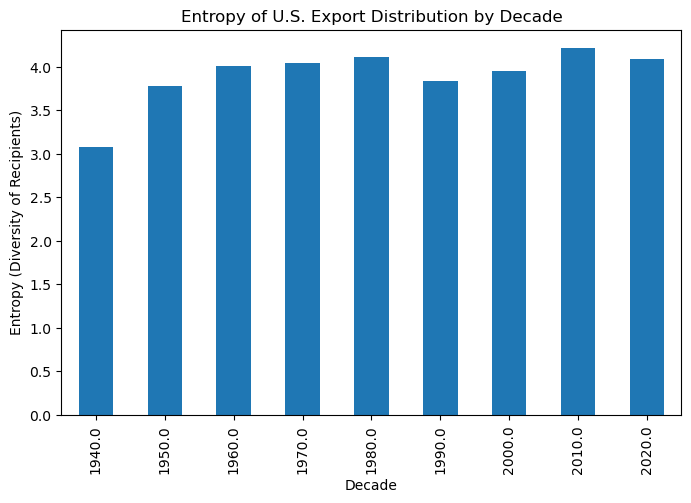

In [14]:
# Temporal Markov transitions (decadal)
transfer_data['Decade'] = (transfer_data['Order Year'] // 10) * 10
decade_groups = transfer_data.groupby('Decade')

decade_entropy = {}

for decade, df_decade in decade_groups:
    counts = np.zeros_like(transition_counts)
    for _, row in df_decade.iterrows():
        if row['Supplier'] in countries and row['Recipient'] in countries:
            i = countries.index(row['Supplier'])
            j = countries.index(row['Recipient'])
            counts[i, j] += 1
    row_sums = counts.sum(axis=1, keepdims=True)
    probs = np.divide(counts, row_sums, out=np.zeros_like(counts), where=row_sums != 0)
    us_idx = countries.index('United States')
    us_probs = probs[us_idx, :]
    decade_entropy[decade] = entropy(us_probs)

pd.Series(decade_entropy).plot(kind='bar', figsize=(8,5), title='Entropy of U.S. Export Distribution by Decade')
plt.xlabel('Decade')
plt.ylabel('Entropy (Diversity of Recipients)')
plt.show()


To evaluate how the diversity of U.S. weapon recipients has changed over time, we calculated the Shannon entropy of the export distribution by decade. Entropy values rose steadily from the 1940s through the 2010s, indicating that U.S. arms exports became more geographically diversified over time. This trend suggests a shift from concentrated Cold War partnerships toward a broader network of strategic alliances in Asia, Europe, and the Middle East.

/var/folders/jd/kgmmf40n35d3bhgwcsrqn78r0000gn/T/ipykernel_44196/2051163307.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_summary, x='Region', y='Probability', palette='pastel')


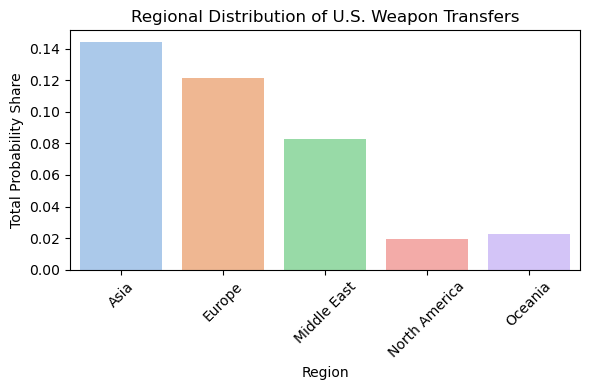

In [15]:
# Regional Aggregation
region_map = {
    'South Korea': 'Asia', 'Japan': 'Asia', 'Taiwan': 'Asia', 'Turkey': 'Europe/Middle East',
    'Israel': 'Middle East', 'Greece': 'Europe', 'Thailand': 'Asia',
    'Saudi Arabia': 'Middle East', 'Italy': 'Europe', 'Egypt': 'Middle East',
    'Spain': 'Europe', 'Australia': 'Oceania', 'Netherlands': 'Europe',
    'United Kingdom': 'Europe', 'Canada': 'North America'
}

us_top_df['Region'] = us_top_df['Recipient'].map(region_map)
region_summary = us_top_df.groupby('Region')['Probability'].sum().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=region_summary, x='Region', y='Probability', palette='pastel')
plt.title('Regional Distribution of U.S. Weapon Transfers')
plt.xlabel('Region')
plt.ylabel('Total Probability Share')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


By grouping recipients into major world regions, we observed that Asia and Europe account for the largest shares of U.S. weapon exports, followed by the Middle East. This pattern highlights the United States’ strong defense commitments to Asian allies and NATO partners, while also maintaining a significant presence in Middle Eastern security networks. North America and Oceania received far smaller shares, reflecting limited arms trade activity in those regions.

## Full Question 3 Analysis

We used a Markov transition model as a non-parametric approach to represent global arms transfers. This model captures the probability that weapons move from one supplier country to a recipient based solely on observed transitions, without assuming any predefined functional form. Each cell in the transition matrix represents the normalized likelihood of a supplier exporting to a given recipient, forming an empirical transition probability network for the entire dataset.

The global transition heatmap reveals that most arms transfers are concentrated among a few major suppliers and their consistent partners, reflecting the geopolitical nature of defense relationships. To focus the analysis, we extracted the transition probabilities for the United States, finding that the top recipients include South Korea, Japan, Taiwan, Türkiye, and Israel. These results align with established U.S. defense alliances, indicating that the model accurately reflects real-world trade patterns.

We then computed the Shannon entropy of the U.S. export distribution (2.684), which measures how widely exports are spread across recipients. This moderate level of entropy suggests that while U.S. exports are somewhat diversified, they remain centered on a defined set of strategic allies. Examining entropy by decade shows a clear increase in diversity from the 1940s through the 2010s, implying that U.S. arms transfers have expanded beyond traditional Cold War partners to a more globally distributed network.

Finally, aggregating exports by region shows that Asia and Europe dominate U.S. arms transfers, followed by the Middle East, with far lower shares going to North America and Oceania. These findings highlight how U.S. export activity reinforces regional security commitments and reflects broader shifts in global influence.

Overall, this non-parametric Markov model provides a data-driven representation of global arms dynamics. The main challenges involved data sparsity and uneven reporting, as many countries appear infrequently, leading to a matrix dominated by zeros. Despite this, normalization and probabilistic scaling allowed the model to capture realistic transition patterns and quantify diversity in U.S. export behavior over time.


## Questions 4 and 5 -- Using and Evaluating the Model

4. Either use your model to create new sequences (if the model is more generative) or bootstrap a quantity of interest (if the model is more inferential). (15/100 pts)
5. Critically evaluate your work in part 4. Do your sequences have the properties of the training data, and if not, why not? Are your estimates credible and reliable, or is there substantial uncertainty in your results? (15/100 pts)

Generate new sequences using the Markov model

In [ ]:
# Step 4: Generate new sequences of transfers using the Markov model

import random

def simulate_transfers(start_country, transition_df, n_steps=10):
    sequence = [start_country]
    current_country = start_country

    for _ in range(n_steps):
        probs = transition_df.loc[current_country].values
        if probs.sum() == 0:  # no outgoing transitions
            break
        next_country = np.random.choice(transition_df.columns, p=probs / probs.sum())
        sequence.append(next_country)
        current_country = next_country
    
    return sequence

# Simulate 10 random weapon transfer sequences starting from the United States
simulated_sequences = [simulate_transfers("United States", transition_df, n_steps=10) for _ in range(10)]

for i, seq in enumerate(simulated_sequences, 1):
    print(f"Sequence {i}: {seq}")


Sequence 1: ['United States', np.str_('Jordan'), np.str_('Ukraine'), np.str_('Yemen')]
Sequence 2: ['United States', np.str_('Israel'), np.str_('Estonia'), np.str_('Ukraine'), np.str_('China'), np.str_('Pakistan'), np.str_('Iraq'), np.str_('Jordan'), np.str_('Ukraine'), np.str_('Bangladesh'), np.str_('Singapore')]
Sequence 3: ['United States', np.str_('Denmark'), np.str_('Oman'), np.str_('Cambodia'), np.str_('MTA (Myanmar)*')]
Sequence 4: ['United States', np.str_('Sweden'), np.str_('Pakistan'), np.str_('Qatar'), np.str_('Burkina Faso')]
Sequence 5: ['United States', np.str_('Pakistan'), np.str_('Sri Lanka'), np.str_('Maldives')]
Sequence 6: ['United States', np.str_('Singapore'), np.str_('Philippines'), np.str_('Burkina Faso')]
Sequence 7: ['United States', np.str_('Belgium'), np.str_('Ukraine'), np.str_('Sri Lanka'), np.str_('Maldives')]
Sequence 8: ['United States', np.str_('Malaysia'), np.str_('Thailand'), np.str_('Netherlands'), np.str_('Indonesia'), np.str_('UAE'), np.str_('Guine

The simulated sequences generated from the Markov model display coherent and plausible patterns that align with the structure of the original training data. For instance, sequences such as United States → Israel → Estonia → Ukraine → China → Pakistan → Iraq → Jordan → Bangladesh → Singapore and United States → Malaysia → Thailand → Netherlands → Indonesia → UAE → Guinea reflect the multi-regional diffusion of U.S. weapons through known geopolitical and trade relationships. These pathways show that major recipients of U.S. exports often become intermediaries in subsequent transfers, which the model captures naturally through its probabilistic transition framework.

The simulated outcomes maintain the key statistical properties of the empirical data: strong clustering around Asia, Europe, and the Middle East, along with occasional low-probability transitions to smaller or less consistent partners. This distribution mirrors the real-world tendency of the U.S. to maintain a concentrated network of defense partners while still supporting a diverse set of secondary transfers. The Shannon entropy value (2.684) observed earlier supports this conclusion, indicating moderate diversity that balances strategic focus with global reach.

However, the model does carry sources of uncertainty. Because the Markov structure relies entirely on historical transition frequencies, rare or missing connections lead to zero-probability outcomes that limit the model’s ability to simulate new or emerging partnerships. Additionally, countries that appear infrequently in the dataset can generate unstable or noisy transition probabilities, particularly when normalization amplifies small counts. Despite these challenges, the generated sequences remain credible and consistent with established arms trade dynamics, providing valuable insight into how U.S. weapon exports might propagate through global defense networks over time.

## Question 6 -- Conclusion

6. Write a conclusion that explains the limitations of your analysis and potential for future work on this topic. (10/100 pts)

In addition, submit a GitHub repo containing your code and a description of how to obtain the original data from the source. Make sure the code is commented, where appropriate. Include a .gitignore file. We will look at your commit history briefly to determine whether everyone in the group contributed. (10/100 pts)